# NSQIP - Random Forests
---



We'll use Random Forests here to build a classifier. The idea behind Random Forests is to fit many decision trees to bootstrap samples of the data. This prevents over-fitting. Our strategy will be:
 - Divide the data into training and testing sets.
 - Choose Random Forest hyper-parameters via cross validation.
 - Fit a Random Forest to the training set with the best hyper-parameters.
 - Check performance on the testing set.

Begin with imports of key libraries, and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as sklm
import random
import warnings 
import math
# warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which response and predictor columns we want to use.

In [2]:
# y is True for bad things happening.
# 'readmission', 'reoperation', 'morbidity', 'mortality', 'infection'
from outcomeVariables import getOutcomeVariable
yFull = getOutcomeVariable(cdf, 'morbidity')


# Drop rows with NaN outcome y data
nanIdx = np.isnan(yFull).nonzero()
yFull = np.delete(yFull.ravel(), nanIdx ,axis=0).reshape(-1,1)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Add a BMI column
cdf.loc[:,'BMI'] = cdf.loc[:,'WEIGHT']*(1/2.20462)/(cdf.loc[:,'HEIGHT']*(1/39.3701)*\
                                                    cdf.loc[:,'HEIGHT']*(1/39.3701))

# List of predictors to keep
keepList1 = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','BMI',\
             'DIABETES','SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT',\
             'HXCOPD','CPNEUMON','HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED',\
             'HXPVD','RENAFAIL','DIALYSIS','CVA','DISCANCR','WNDINF-','STEROID','WTLOSS',\
             'BLEEDDIS','PROPER30','ASACLASS','FNSTATUS1','RBC']
# An additional list of predictors that might be interesting
keepList2 = ['ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH',\
             'PRWBC','PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY','ESOVAR','RESTPAIN',\
             'HXTIA','TRANSFUS','CHEMO','RADIO','PRSEPSIS','PREGNANCY','EMERGNCY',\
             'OPTIME','MALLAMP']

# Combine the lists
keepList = keepList1 + keepList2
# Make a list of any column in cdf whose name starts with a string in keepList
colsToKeep = [colName for colName in cdf.columns \
              if np.any([colName.startswith(keepItem) for keepItem in keepList])]
cdf = cdf[colsToKeep]

We will drop predictors that don't have any variance. (This can happen because we already dropped a bunch of cases for which our outcomes are not recorded.)

These regression models will fail on missing data, so we'll impute missing data for each column by setting it equal to the mean.

Since our regularization penalty is based on the size of the coefficients, we need to scale each column to have equal mean and variance. We don't need to add an intercept column; sklearn gives us an intercept as a fit option.

In [3]:
# Protect against only having one value in the columns.
# (Imputer will drop these columns, and then we won't know the names...)
for colName in cdf.columns:
    colData = cdf[colName]
    uniques = np.unique(colData)
    nonNanUniques = [item for item in uniques if ~np.isnan(item)]
    if len(nonNanUniques) < 2:
        print('Not enough variance, dropping column: %s' % colName)
        cdf.drop(colName, axis=1, inplace=True)

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
X = pd.DataFrame(X, columns=colNames)

# No need to scale the columns for Random Forests
# X = StandardScaler().fit_transform(X)
# scaledX = pd.DataFrame(X, columns=colNames)
scaledX = X

We break the data into separate fractions for training (2/3) and testing (1/3). All of our fitting and cross-validation will be done on the training set. The testing set will be held out to evaluate the final model performance.

In [4]:
# Split for validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledX, yFull, test_size=0.33)
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [5]:
rfc = RandomForestClassifier(n_estimators=1000)
tunedParam = 'max_depth'
tuned_parameters = [{tunedParam: [1,2,5,10,20,50],\
                     'criterion': ['gini','entropy'],\
                     'max_features': ['sqrt','log2'],\
                     'oob_score': [True, False]}]
gscv = GridSearchCV(rfc,tuned_parameters,cv=10,scoring='roc_auc',verbose=1)
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 41.0min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed: 95.8min
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 104.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 20, 50], 'oob_score': [True, False], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

Best Params: 
{'criterion': 'entropy', 'max_depth': 10, 'oob_score': True, 'max_features': 'sqrt'}


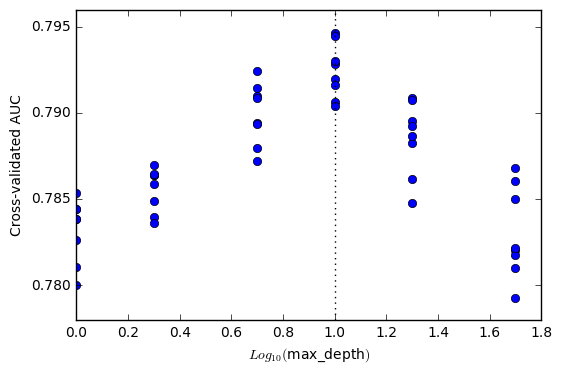

In [6]:
gscv.grid_scores_
print('Best Params: ')
print(gscv.best_params_)
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params[tunedParam] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means,'bo')
bestC = gscv.best_params_[tunedParam]
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}($' + tunedParam + '$)$')
plt.ylabel('Cross-validated AUC')
plt.show()

Plot ROC curves for in-sample training data, and test data, for both the full and reduced model. The test data here was not used to fit the model at all, so it should approximate how our model will perform prospectively on new data. Furthermore, if we've done a good job regularizing, the in-sample performance should be pretty close to the test data performance.

In-sample ROC AUC = 0.937 
Test ROC AUC = 0.793 


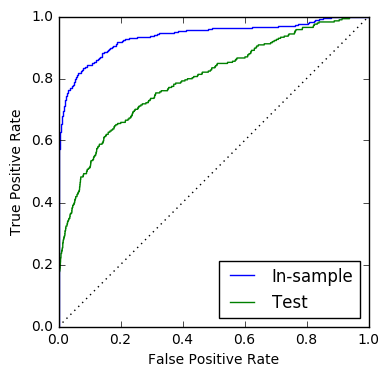

In [7]:
# Plot an ROC curve for training
plt.clf
pred_train = gscv.predict_proba(X_train)[:,1]
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

# Plot an ROC curve for test data
pred_test = gscv.predict_proba(X_test)[:,1]
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

# Format the ROC plot
plt.plot([0, 1], [0, 1], color='k', linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()